# Energy vs Power cell example

This notebook shows how to use PyBaMM to simulate an energy cell vs a power cell by changing the thickness of the electrodes. This example requires the IDAKLUSolver, so make sure you use PyBaMM 25.1 so that it is available on whatever platform you are using.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pybamm

print(f"PyBaMM version: {pybamm.__version__}")

PyBaMM version: 25.1.0


## Simple simulation

Now, let's set up and a simple simulation. The arguments into the simulation are the model, which we will use the standard DFN for; the parameter set, which we will use the "Chen2020" parameter set; the experiment, i.e., a current or power profile; and the numerical solver.

In [2]:
import pybamm

model = pybamm.lithium_ion.DFN()

parameter_values = pybamm.ParameterValues("Chen2020")

experiment = pybamm.Experiment(
    ["Discharge at 1C until 2.5V"]
    )

solver = pybamm.IDAKLUSolver()

sim = pybamm.Simulation(model=model,
                        parameter_values=parameter_values,
                        experiment=experiment,
                        solver=solver)

sol = sim.solve(initial_soc=1)

When the simulation completes, let's look at the voltage response and calculate the cell energy and mean power.

Mean power: 18.26 W
Discharge energy: 17.47 Wh


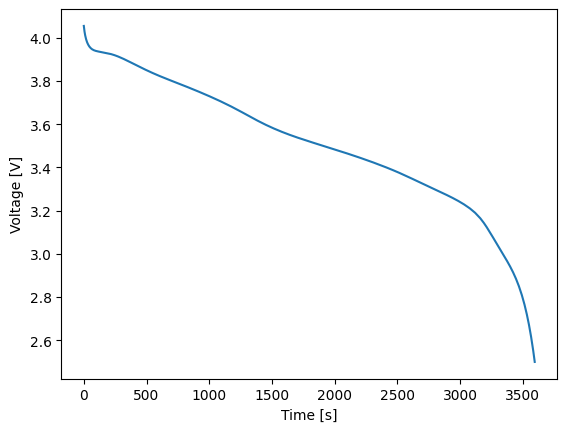

In [3]:
time = sol["Time [s]"].data
power = sol["Power [W]"].data
voltage = sol["Voltage [V]"].data
energy = np.cumsum(power * np.diff(np.append(0, time))) / 3600

fig, ax = plt.subplots()
ax.plot(time, voltage)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Voltage [V]")

print(f"Mean power: {np.mean(power):.2f} W")
print(f"Discharge energy: {energy[-1]:.2f} Wh")

## Sweeping C-rate

By sweeping the C-rate, we can see how the power and energy change (higher C-rate means higher power and lower energy).

In [4]:
C_rates = [0.1, 0.2, 0.5, 0.75, 1, 1.5, 2, 2.25, 2.5, 3, 3.5, 4, 5, 7.5, 10]

def sweep_c_rate(C_rates, parameter_values):

    outputs = {
            "C-rate": C_rates,
            "Energy [Wh]": [],
            "Discharge Energy [Wh]": [],
            "Time [s]": [],
            "Voltage [V]": [],
            "Mean Power [W]": []
            }

    for C_rate in C_rates:

        experiment = pybamm.Experiment(
            [f"Discharge at {C_rate}C until 2.5V"]
            )

        sim = pybamm.Simulation(model,
                                parameter_values=parameter_values,
                                experiment=experiment,
                                solver=solver
                                )

        sol = sim.solve(initial_soc=1)

        time = sol["Time [s]"].data
        power = sol["Power [W]"].data
        voltage = sol["Voltage [V]"].data

        energy = np.cumsum(power * np.diff(np.append(0, time))) / 3600
        discharge_energy = energy[-1]

        outputs["Voltage [V]"].append(voltage)
        outputs["Time [s]"].append(time)
        outputs["Energy [Wh]"].append(energy)
        outputs["Discharge Energy [Wh]"].append(discharge_energy)
        outputs["Mean Power [W]"].append(np.mean(power))

    return outputs

outputs_energy_cell = sweep_c_rate(C_rates, parameter_values)

Text(0.5, 0.98, 'Energy cell')

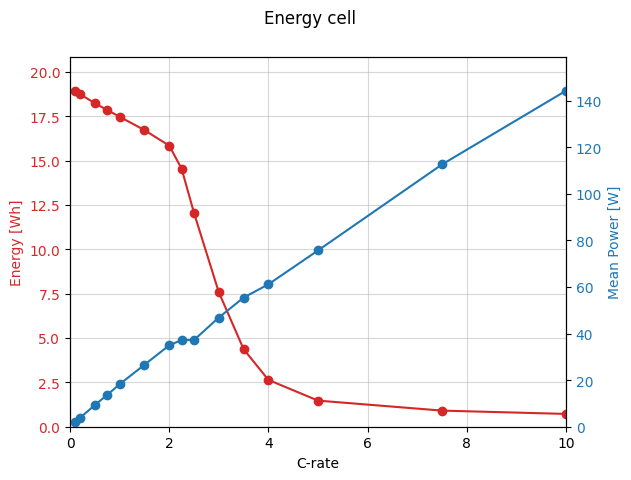

In [5]:
def plot_power_vs_energy(outputs):

    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.set_xlabel("C-rate")

    ax.plot(outputs["C-rate"], outputs["Discharge Energy [Wh]"], "-o", color="tab:red")
    ax.set_ylabel("Energy [Wh]", color="tab:red")
    ax.tick_params(axis="y", labelcolor="tab:red")
    ax.set_ylim(0, outputs["Discharge Energy [Wh]"][0] * 1.1)

    # add a twin axis for time on a log scale
    ax2.plot(outputs["C-rate"], outputs["Mean Power [W]"], "-o", color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")
    ax2.set_ylabel("Mean Power [W]", color="tab:blue")
    ax2.set_xlim(0, outputs["C-rate"][-1])
    ax2.set_ylim(0, outputs["Mean Power [W]"][-1] * 1.1)

    ax.grid(alpha=0.5)

    return fig, ax

fig, ax = plot_power_vs_energy(outputs_energy_cell)
fig.suptitle("Energy cell")


Text(0.5, 0.98, 'Energy cell')

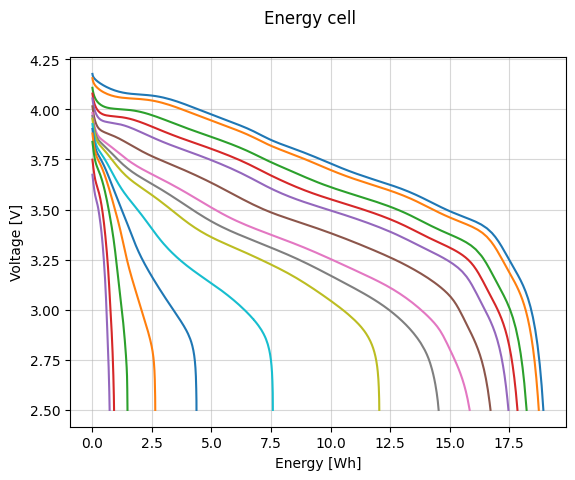

In [6]:
def plot_voltage_vs_energy(outputs):

    fig, ax = plt.subplots()

    for voltage, energy in zip(outputs["Voltage [V]"], outputs["Energy [Wh]"]):
        ax.plot(energy, voltage)
    ax.set_xlabel("Energy [Wh]")
    ax.set_ylabel("Voltage [V]")

    ax.grid(alpha=0.5)

    return fig, ax

fig, ax = plot_voltage_vs_energy(outputs_energy_cell)
fig.suptitle("Energy cell")


This is an energy cell with a maximum C-rate of 2C, so the energy drops off significantly as the C-rate increases above 2C

## Changing electrode thickness

We can also sweep the electrode thickness to see how the power and energy change. We will change the thickness of the positive electrode and the negative electrode proportionally to avoid having to change the N/P ratio and electrode balance.

Text(0.5, 0.98, 'Power cell')

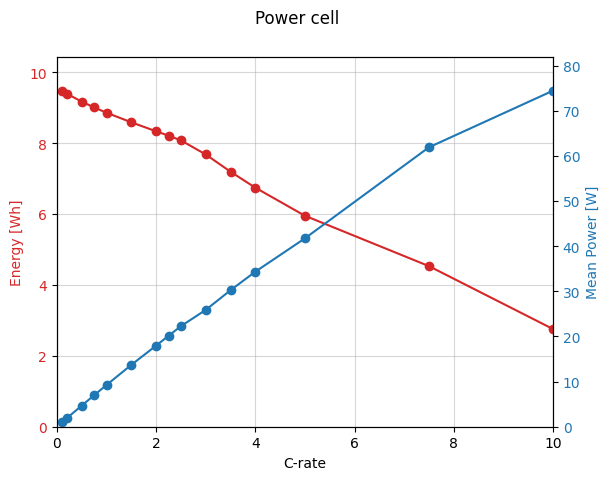

In [7]:
parameter_values_power_cell = pybamm.ParameterValues("Chen2020")
parameter_values_power_cell["Negative electrode thickness [m]"] *= 1/2
parameter_values_power_cell["Positive electrode thickness [m]"] *= 1/2

# Change the nominal cell capacity so that "C-rate" translates to the appropriate power
parameter_values_power_cell["Nominal cell capacity [A.h]"] *= 1/2

outputs_power_cell = sweep_c_rate(C_rates, parameter_values_power_cell)
fig, ax = plot_power_vs_energy(outputs_power_cell)
fig.suptitle("Power cell")


The power cell maintains its capacity better at higher C-rates. The downside of the power cell is that it has a lower specific energy since the ratio of active material to inactive material (current collector, separator, etc.) is higher. PyBaMM does not provide a specific energy / specific power, so you would need to define your own function for how cell mass depends on parameters to get specific energy and specific power.

Here, we can just compare normalized energy and power.

Text(0.5, 0.98, 'Energy cell (o) vs Power cell (x)')

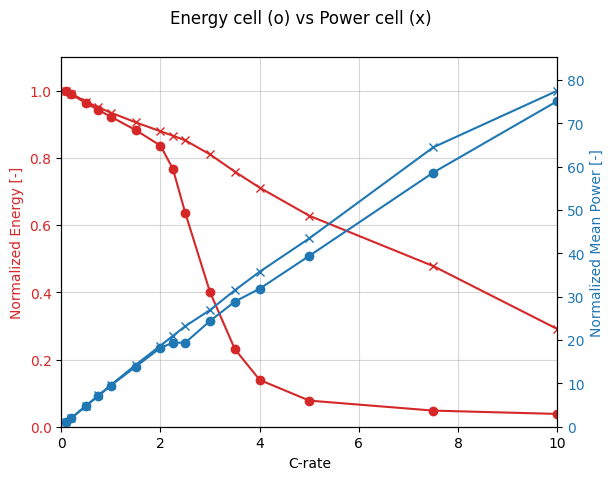

In [8]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.set_xlabel("C-rate")

styles = ["-o", "-x"]

for outputs, style in zip([outputs_energy_cell, outputs_power_cell], styles):

    normalized_energy = outputs["Discharge Energy [Wh]"] / outputs["Discharge Energy [Wh]"][0]
    ax.plot(outputs["C-rate"], normalized_energy, style, color="tab:red")
    ax.set_ylabel("Normalized Energy [-]", color="tab:red")
    ax.tick_params(axis="y", labelcolor="tab:red")
    ax.set_ylim(0, 1.1)

    normalized_power = outputs["Mean Power [W]"] / outputs["Mean Power [W]"][0]
    ax2.plot(outputs["C-rate"], normalized_power, style, color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")
    ax2.set_ylabel("Normalized Mean Power [-]", color="tab:blue")
    ax2.set_xlim(0, outputs["C-rate"][-1])
    ax2.set_ylim(0, normalized_power[-1] * 1.1)

ax.grid(alpha=0.5)

fig.suptitle("Energy cell (o) vs Power cell (x)")
